# Vårt superprosjekt

## a

We initalize and test the functionality of Qiskit as follows

In [1]:
from qiskit import QuantumCircuit,Aer,assemble, ClassicalRegister,QuantumRegister
from qiskit.visualization import array_to_latex, plot_histogram
import numpy as np
import matplotlib.pyplot as plt
simulator = Aer.get_backend('aer_simulator')

In [2]:
qr = QuantumRegister(1, 'Qreg')
cr = ClassicalRegister(1, 'Creg')

qc = QuantumCircuit()
qc.add_register(qr)
qc.add_register(cr)
#qc.save_statevector()

qc.x(0)
qc.y(0)
qc.z(0)
qc.h(0)
qc.p(np.pi/2, 0)


qc.draw()

┌───┐┌───┐┌───┐┌───┐┌────────┐
  Qreg: ┤ X ├┤ Y ├┤ Z ├┤ H ├┤ P(π/2) ├
        └───┘└───┘└───┘└───┘└────────┘
Creg: 1/══════════════════════════════

Initialize a Bell state by applying Haddamard to G0 and CNOT on G1, using G0 as control gate.

In [3]:
qc_2 = QuantumCircuit()

qr_2 = QuantumRegister(2, 'qreg')
qc_2.add_register(qr_2)

cr_2 = ClassicalRegister(2, 'creg')
qc_2.add_register(cr_2)
qc_2.h(0)
qc_2.cx(0,1)
qc_2.save_statevector()
qc_2.measure(qr_2[0], cr_2[0])
qc_2.measure(qr_2[1], cr_2[1])
qc_2.draw()

┌───┐      statevector ┌─┐   
qreg_0: ┤ H ├──■────────░──────┤M├───
        └───┘┌─┴─┐      ░      └╥┘┌─┐
qreg_1: ─────┤ X ├──────░───────╫─┤M├
             └───┘      ░       ║ └╥┘
creg: 2/════════════════════════╩══╩═
                                0  1

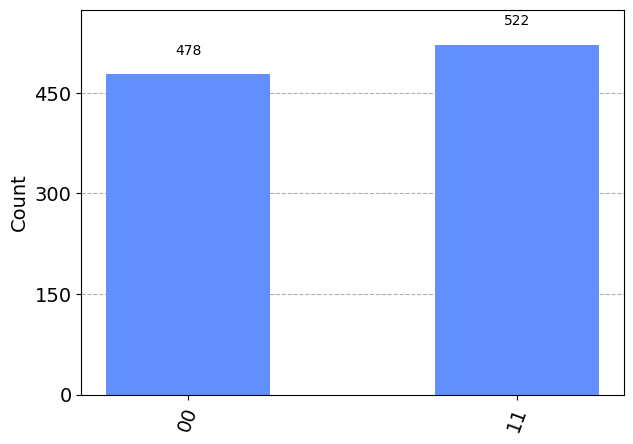

In [4]:
job = simulator.run(qc_2, shots=1000)
hist = job.result().get_counts()
plot_histogram(hist)

This is statistically in accordance with the expected Bell states.

## b


Here we initialize the Hamiltonian matrices and solve it using eigsolvers.


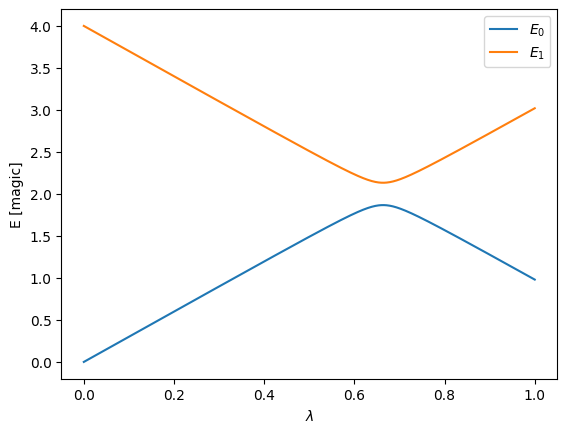

In [5]:
H0 = np.eye(2)
E1 = 0; E2 = 4
H0[0,0] = E1; H0[1,1] = E2


H1 = np.eye(2)
v11 = 3; v22 = -v11; v12 = 0.2; v21 = v12
H1[0,0] = v11; H1[0,1] = v12; H1[1,0] = v21; H1[1,1] = v22 

pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12

n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,2))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)
for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    # print(H_)
    Es[i,:] = eig_val
    C1s[i,:] = eig_vec[:,0]
    C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

## c


In [6]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from functools import partial
from scipy.optimize import minimize
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Z, I

optimizer = partial(minimize, method="L-BFGS-B")

False


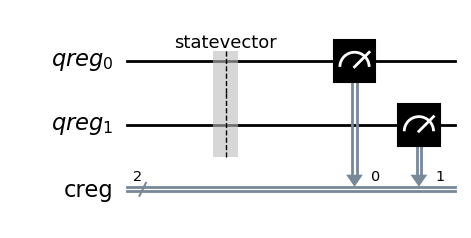

In [17]:
qc_3 = QuantumCircuit()

qr_3 = QuantumRegister(2, 'qreg')
qc_3.add_register(qr_3)

cr_3 = ClassicalRegister(2, 'creg')
qc_3.add_register(cr_3)

eta = (E1 + E2)/2
Omega = (E1-E2)/2
H0 = eta*np.eye(2) + Omega*pauli_z
are = Operator(Pauli('X'))

H1 = c * np.eye(2) + omega_z * pauli_z + omega_x * pauli_x
#I = Operator( Pauli('X') )

X_op = Operator(Pauli('XX'))
Z_op = Operator(Pauli('ZZ'))
idty = Operator(np.eye(4))

op_ = eta*idty + Omega*Z_op + lmd_*(c*idty + omega_z*Z_op + omega_x * X_op)
print(op_.is_unitary())
#Trenger en unitær operator for å klare å implementere det. Noen idé?

qc_3.save_statevector()
qc_3.measure(qr_3[0], cr_3[0])
qc_3.measure(qr_3[1], cr_3[1])
qc_3.draw('mpl')

In [18]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

In [19]:
#Testoperator
# Her følger du denne right? https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html
# Ville tengt at det var lettere å gjøre noe ala https://github.com/CompPhysics/QuantumComputingMachineLearning/blob/gh-pages/doc/pub/week10/ipynb/week10.ipynb
# men jeg vet ikke, kan ikke noe om qiskit hehe
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(H2_op)
ansatz_ = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
vqe = VQE(ansatz= ansatz_, optimizer=SLSQP(maxiter=1000))

-1.052373245772859 * II
+ 0.39793742484318045 * IZ
- 0.39793742484318045 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423156 * XX


TypeError: VQE.__init__() missing 1 required positional argument: 'estimator'